In [2]:
install.packages("sandwich")
install.packages("coefplot")

Installing package into 'C:/Users/Kaiyan Zhang/AppData/Local/R/win-library/4.4'
(as 'lib' is unspecified)



package 'sandwich' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\Kaiyan Zhang\AppData\Local\Temp\RtmpgJ2JXz\downloaded_packages


Installing package into 'C:/Users/Kaiyan Zhang/AppData/Local/R/win-library/4.4'
(as 'lib' is unspecified)



package 'coefplot' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\Kaiyan Zhang\AppData\Local\Temp\RtmpgJ2JXz\downloaded_packages


In [3]:
library(geojsonio)
library(tidyverse)
library(ggplot2)
library(tidyr)
library(dplyr)
library("knitr")
library(broom)
library(stargazer)
library(units)
library(sf)
library(car)
library(sandwich)
library(coefplot)


Warning message:
"package 'geojsonio' was built under R version 4.4.2"
Registered S3 method overwritten by 'geojsonsf':
  method        from   
  print.geojson geojson


Attaching package: 'geojsonio'


The following object is masked from 'package:base':

    pretty


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Please cite as: 


 Hlavac, Marek (2022). stargazer: Well-Formatted Regression and Summary Statistics Tables.

 R package version 5.2.3. https://CRAN.R-project.org/package=stargazer 


udunits database from

In [4]:
# Read in the data
census_index_crime <- st_read("census_index_crime.geojson") |>
    mutate(across(c(immigrant_prop, education_prop, mean_land_value,income), as.double))|>
    na.omit()|>
    glimpse()

Reading layer `census_index_crime' from data source 
  `C:\Users\Kaiyan Zhang\Desktop\econ326\census_index_crime.geojson' 
  using driver `GeoJSON'
Simple feature collection with 993 features and 18 fields
Geometry type: MULTIPOLYGON
Dimension:     XY
Bounding box:  xmin: -123.2242 ymin: 49.19853 xmax: -123.0229 ymax: 49.31408
Geodetic CRS:  WGS 84


Warning message:
"There were 4 warnings in `stopifnot()`.
The first warning was:
ℹ In argument: `across(...)`.
Caused by warning:
! NAs introduced by coercion
ℹ Run `dplyr::last_dplyr_warnings()` to see the 3 remaining warnings."


Rows: 989
Columns: 19
$ name                 <chr> "59150307", "59150308", "59150309", "59150310", "…
$ households           <int> 254, 203, 269, 283, 181, 203, 402, 170, 333, 174,…
$ dwellings            <int> 273, 223, 299, 310, 199, 211, 418, 181, 356, 189,…
$ population           <int> 632, 501, 745, 536, 532, 562, 1088, 556, 959, 506…
$ population_density   <dbl> 2110.9, 4575.3, 6663.7, 4895.0, 6567.9, 6445.0, 6…
$ region               <chr> "Vancouver", "Vancouver", "Vancouver", "Vancouver…
$ area_sq_km           <dbl> 0.29926, 0.10956, 0.11190, 0.10940, 0.08094, 0.08…
$ age                  <int> 630, 500, 745, 540, 530, 560, 1085, 555, 960, 510…
$ income               <dbl> 0.90965, 0.93611, 0.84736, 0.45184, 0.82517, 0.74…
$ immigrant_prop       <dbl> 0.2610759, 0.2894212, 0.3557047, 0.2891791, 0.404…
$ education_prop       <dbl> 0.3085443, 0.2794411, 0.3154362, 0.1865672, 0.253…
$ school_index         <dbl> 1.074675, 1.252273, 1.426336, 2.441091, 1.543095,…
$ light_index     

In [5]:
census_save <- census_index_crime|>
    st_drop_geometry()

write.csv(census_save, "census_index_crime.csv")


Warning message:
"Using an external vector in selections was deprecated in tidyselect 1.1.0.
ℹ Please use `all_of()` or `any_of()` instead.
  # Was:
  data %>% select(regressors)

  # Now:
  data %>% select(all_of(regressors))

See <https://tidyselect.r-lib.org/reference/faq-external-vector.html>."


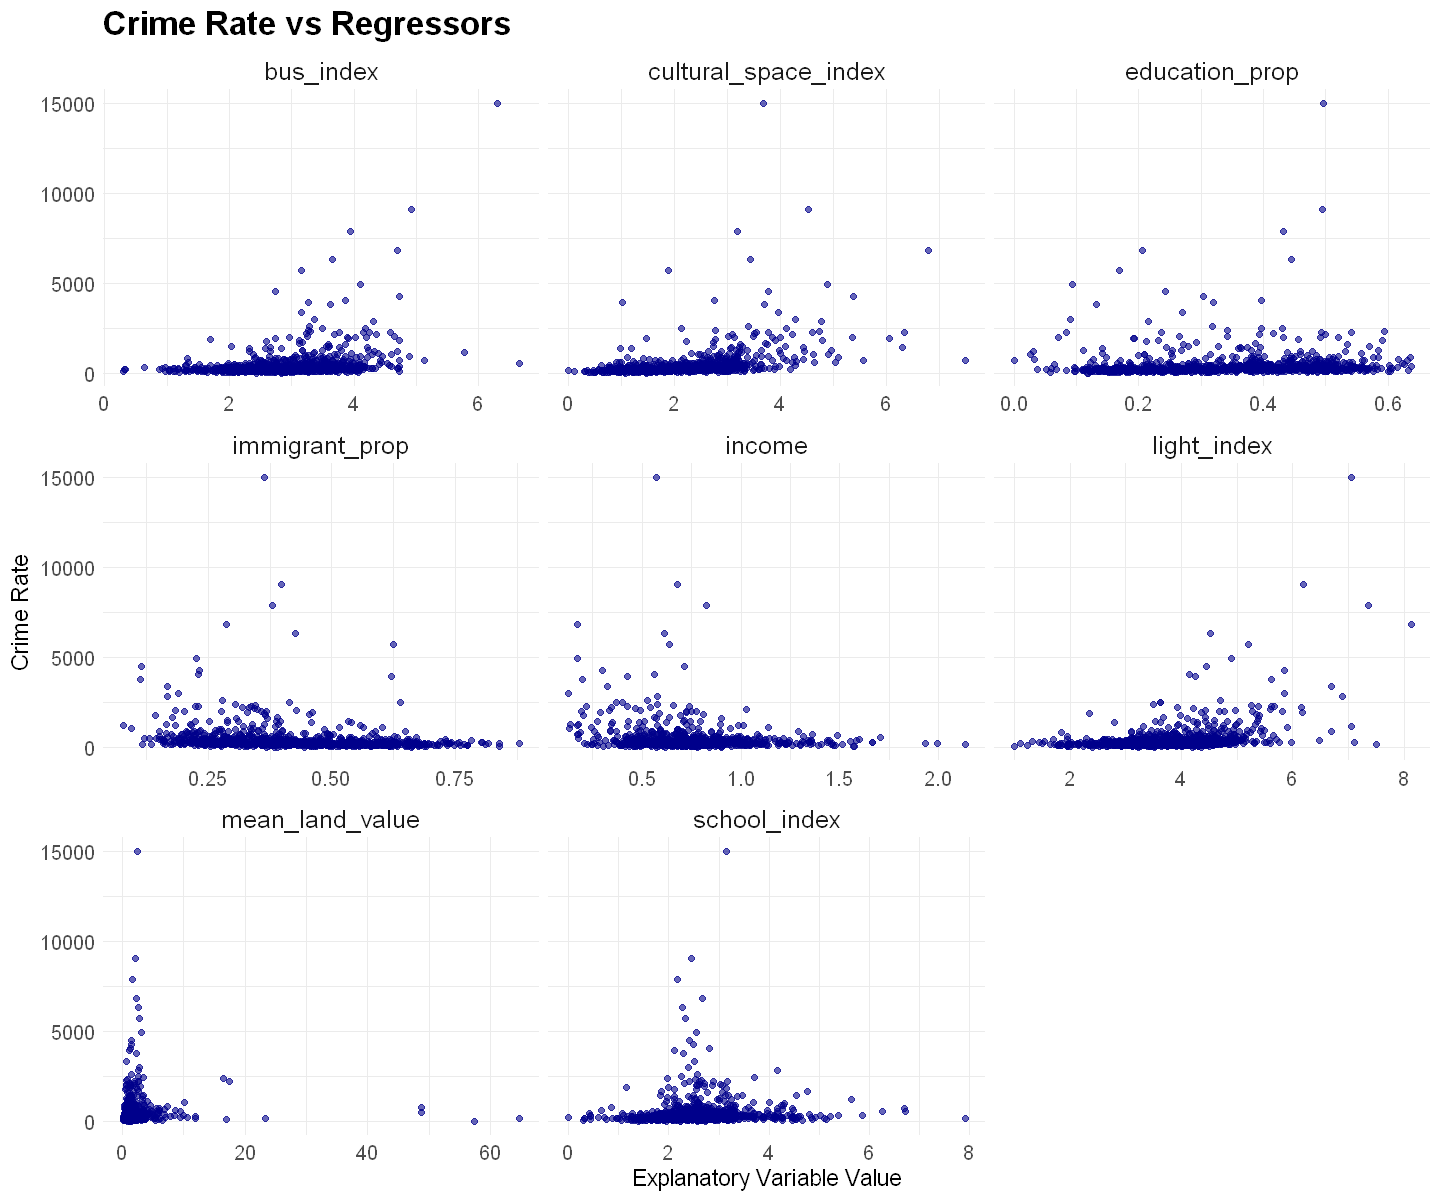

In [6]:
# Visualization of crime rate against regressors
options(repr.plot.width = 12, repr.plot.height = 10)

regressors <- c('mean_land_value','school_index', 'light_index', 'bus_index', 'cultural_space_index', 'income', 'immigrant_prop', 'education_prop')

long_data <- census_index_crime |>
  pivot_longer(cols = regressors,
               names_to = "regressor",
               values_to = "value")

variables_scatter <- ggplot(long_data, aes(x = value, y = crime_rate)) +
  geom_point(color = "darkblue", alpha = 0.6) +
  facet_wrap(~ regressor, scales = "free_x") + 
  labs(title = "Crime Rate vs Regressors",
       x = "Explanatory Variable Value",
       y = "Crime Rate") +
  theme_minimal() +
  theme(plot.title = element_text(size = 20, face = "bold"),
        strip.text = element_text(size = 15),  
        axis.title = element_text(size = 14),
        axis.text = element_text(size = 12))

variables_scatter

By eyeball method, it's clear that the data is itself heteoskedastic.

In [7]:
# Carry out all the simple regressions
outcome <- "crime_rate"

simple_regressions <- map(regressors, ~ lm(as.formula(paste(outcome, "~", .x)), data = census_index_crime))

names(simple_regressions) <- regressors

stargazer(simple_regressions, type = "text",
          title = "Simple Regression Results",
          dep.var.labels = c("Crime Rate"))


Simple Regression Results
                                                                   Dependent variable:                                     
                               --------------------------------------------------------------------------------------------
                                                                        Crime Rate                                         
                                  (1)        (2)         (3)         (4)         (5)         (6)         (7)        (8)    
---------------------------------------------------------------------------------------------------------------------------
mean_land_value                  6.156                                                                                     
                                (7.024)                                                                                    
                                                                                                         

`geom_smooth()` using formula = 'y ~ x'


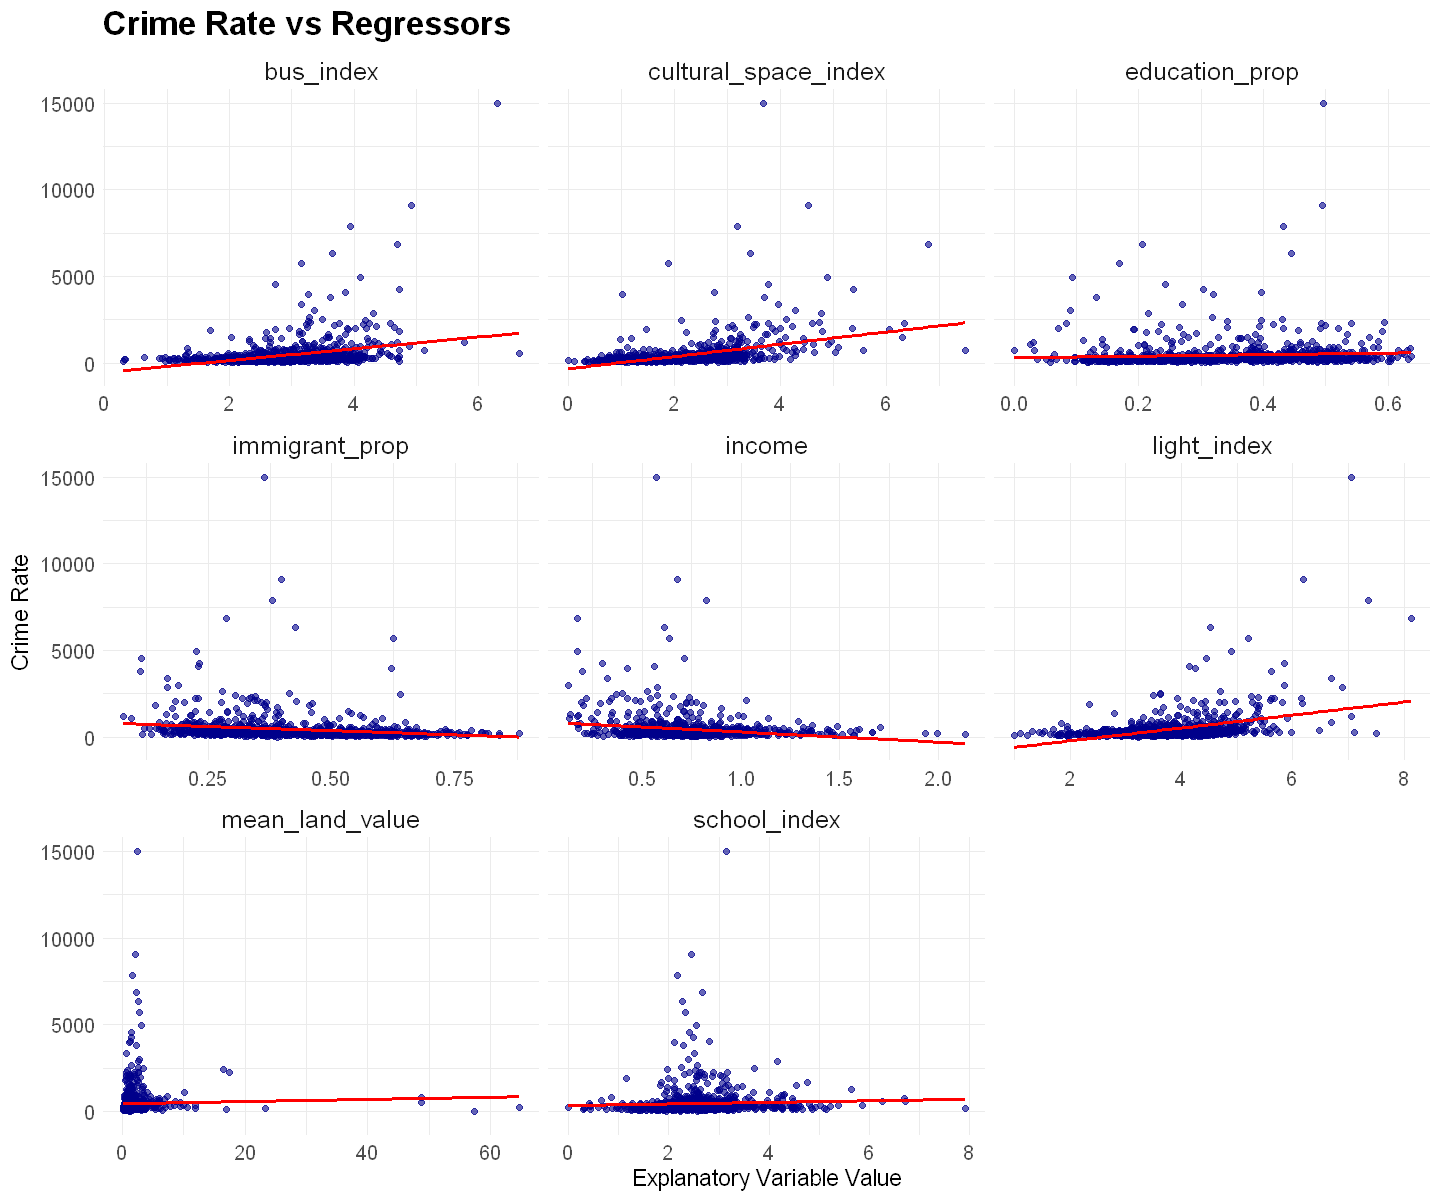

In [8]:
# Visualizing simple regressions
options(repr.plot.width = 12, repr.plot.height = 10)
simple_regression_plot <- variables_scatter +  geom_smooth(method = "lm", se = FALSE, color = "red") 

simple_regression_plot

In [9]:
# Test by running a model including all control
reg_all <- lm(crime_rate ~ mean_land_value + school_index + light_index + bus_index + cultural_space_index + 
    income + immigrant_prop + education_prop, data = census_index_crime)
    
stargazer(reg_all, type = "text",
          title = "Regression With All Variable Results",
          dep.var.labels = c("Crime Rate"))


Regression With All Variable Results
                         Dependent variable:    
                     ---------------------------
                             Crime Rate         
------------------------------------------------
mean_land_value                 7.986           
                               (6.161)          
                                                
school_index                 -288.336***        
                              (36.379)          
                                                
light_index                  373.969***         
                              (46.948)          
                                                
bus_index                      27.590           
                              (51.888)          
                                                
cultural_space_index         180.362***         
                              (44.134)          
                                                
income                       -2

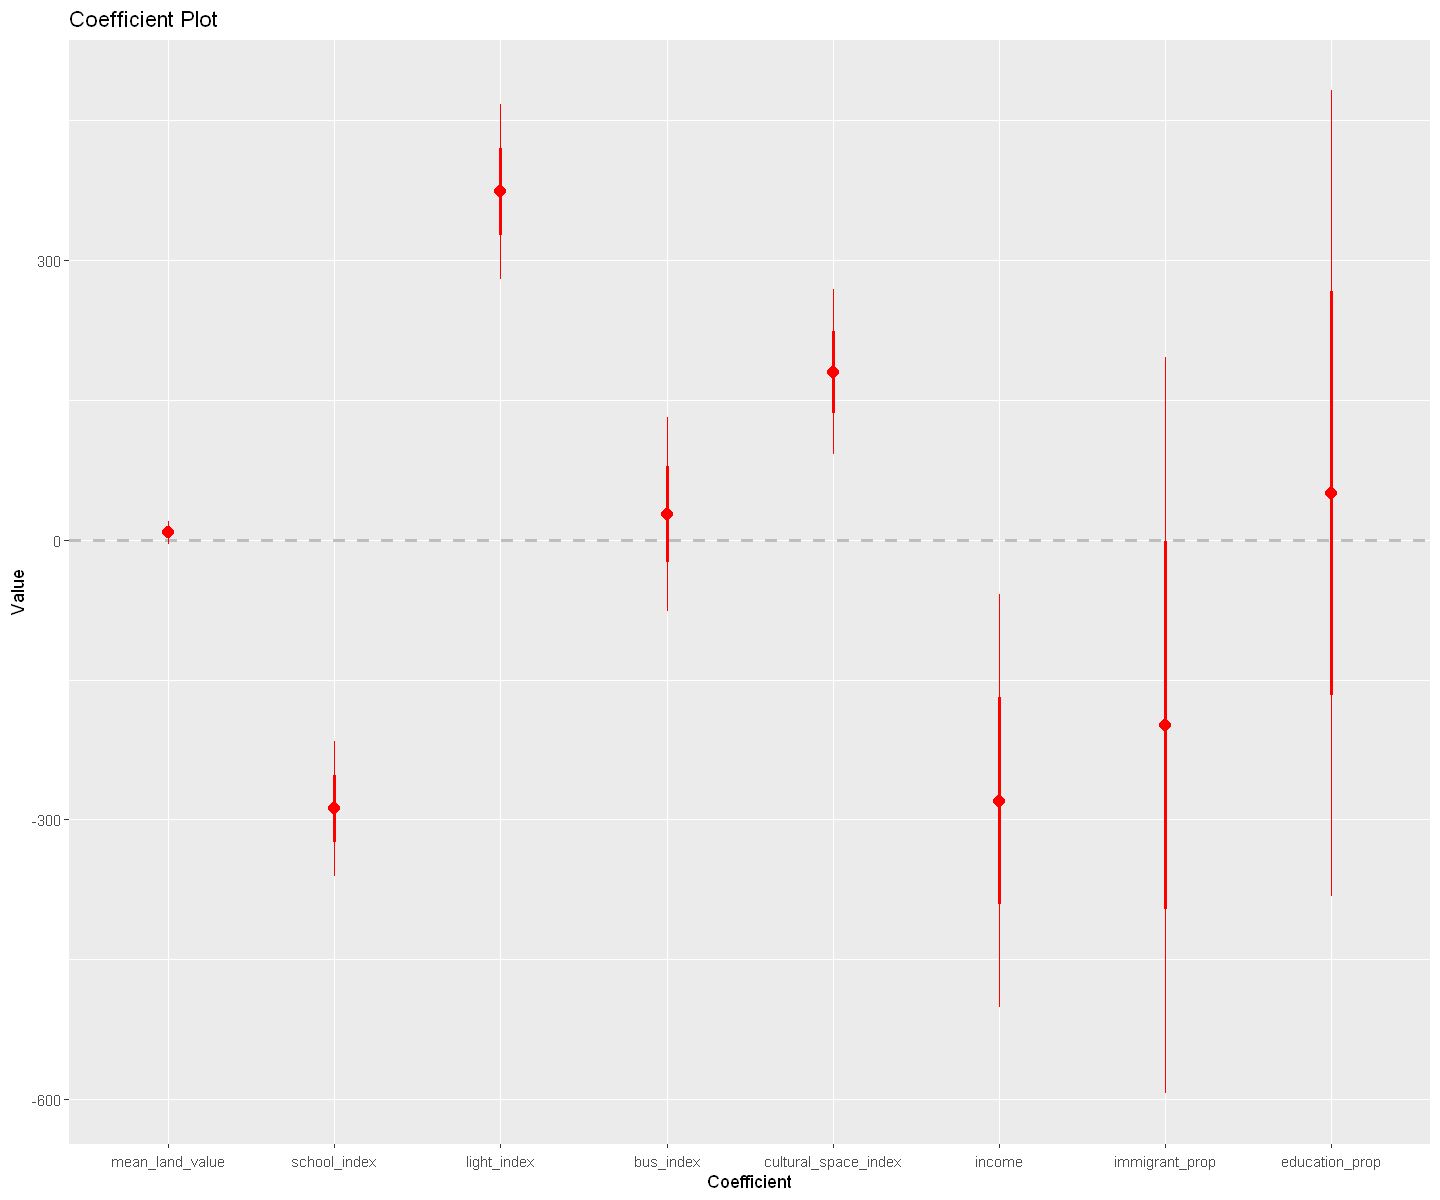

In [10]:
coefplot(reg_all, intercept = FALSE, horizontal = TRUE, color = "red")

The regression output above suggests that bus_index, immigrant_prop, and education_prop variables may be insignificant for having p-values > 0.1

In [11]:
# Examining the vif of the model
vif(reg_all, type = "terms")|>
tidy()

Warning message in tidy.numeric(vif(reg_all, type = "terms")):
"'tidy.numeric' is deprecated.
See help("Deprecated")"


names,x
<chr>,<dbl>
mean_land_value,1.023274
school_index,1.607963
light_index,3.238826
bus_index,3.080453
cultural_space_index,3.217783
income,1.401230
immigrant_prop,1.630053
education_prop,1.571709


In [12]:
# Predict y_hat
y_hat <- predict(reg_all)

In [13]:
# Carry out white's test
white <- lm(reg_all$residuals^2 ~ y_hat + I(y_hat^2))

stargazer(white, type = "text",
          title = "White's Test",
          dep.var.labels = c("Residual"))


White's Test
                        Dependent variable:    
                    ---------------------------
                             Residual          
-----------------------------------------------
y_hat                      -1,741.469**        
                             (734.848)         
                                               
I(y_hat2)                    3.609***          
                              (0.467)          
                                               
Constant                    -83,925.540        
                           (280,217.100)       
                                               
-----------------------------------------------
Observations                    989            
R2                             0.098           
Adjusted R2                    0.096           
Residual Std. Error  5,622,803.000 (df = 986)  
F Statistic           53.583*** (df = 2; 986)  
Note:               *p<0.1; **p<0.05; ***p<0.01


In [14]:
# Continuing on white's test
linearHypothesis(white, c("y_hat = 0", "I(y_hat^2) = 0"))

,Res.Df,RSS,Df,Sum of Sq,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,988,3.456141e+16,NA,NA,NA,NA
2,986,3.117329e+16,2,3.388127e+15,53.58262,8.113556e-23


The extremely small p-value suggests rejecting the null hypothesis that residuals are constant.
This means there is strong evidence of heteroskedasticity in the data. We need to use robust standard errors to resolve this issue.

In [15]:
reg1 <- lm(crime_rate ~ school_index + light_index + cultural_space_index + 
    income, data = census_index_crime)

stargazer(reg1, type = "text",
          title = "Regression With Significant Controls",
          dep.var.labels = c("Crime Rate"))


Regression With Significant Controls
                         Dependent variable:    
                     ---------------------------
                             Crime Rate         
------------------------------------------------
school_index                 -287.323***        
                              (34.776)          
                                                
light_index                  369.548***         
                              (36.862)          
                                                
cultural_space_index         217.168***         
                              (32.014)          
                                                
income                       -259.734***        
                              (97.443)          
                                                
Constant                     -479.589***        
                              (133.759)         
                                                
-------------------------------

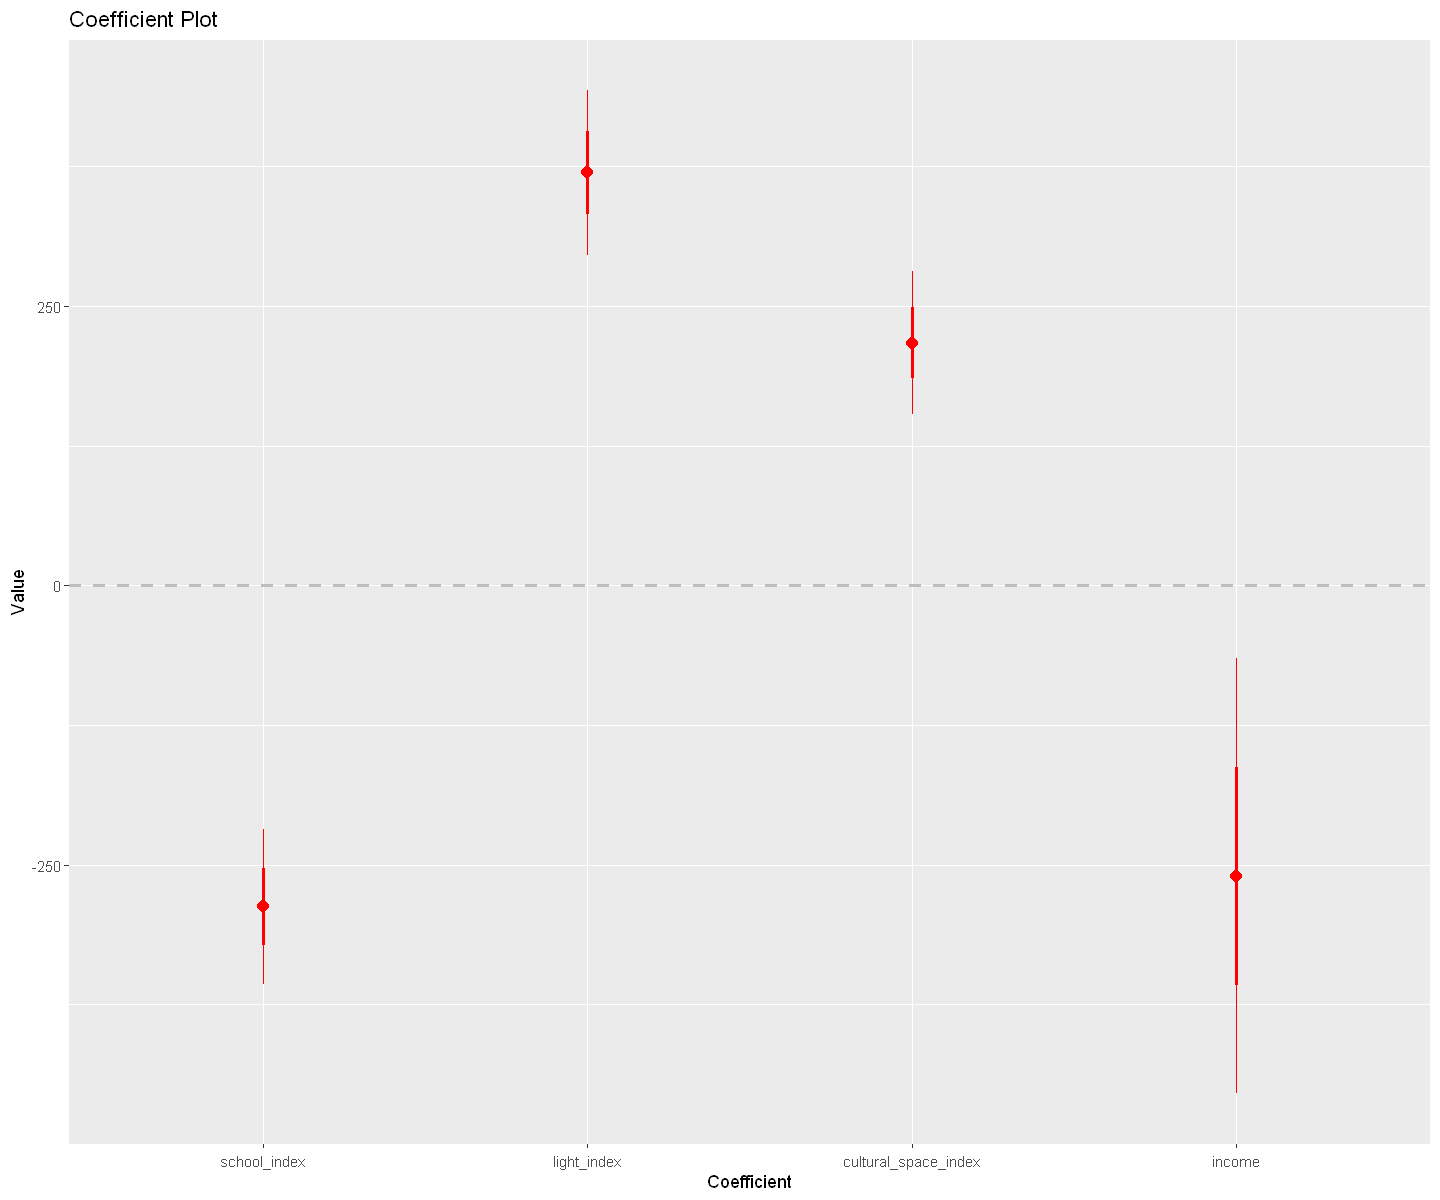

In [16]:
coefplot(reg1, intercept = FALSE, horizontal = TRUE, color = "red")

In [17]:
stargazer(simple_regressions, reg1, reg_all,
          type = "text", 
          title = "Regression Results",
          dep.var.labels = c("Crime Rate","Crime Rate"))


Regression Results
                                                                                                                               Dependent variable:                                                                                                           
                     ----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
                                                                                                            Crime Rate                                                                                                          Crime Rate                   
                             (1)                 (2)                   (3)                      (4)                      (5)                      (6)                     (7)                    (8)                    (9

We want to make sure what made land_value and bus_index insignificant and school_index significant in our model with all variables, so we continue to run other models.

In [18]:
# Regressions with land_value always present
regressors_without_land_value <- c( 'school_index','light_index', 'bus_index', 'cultural_space_index', 'income', 'immigrant_prop', 'education_prop')
reg_with_land_value <-  map(regressors, ~ lm(as.formula(paste(outcome, "~ mean_land_value +", .x)), data = census_index_crime))

names(reg_with_land_value) <- regressors

stargazer(reg_with_land_value, type = "text",
          title = "Regression Results",
          dep.var.labels = c("Crime Rate"))


Regression Results
                                                                                                     Dependent variable:                                                                                 
                     ------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
                                                                                                          Crime Rate                                                                                     
                             (1)                 (2)                   (3)                     (4)                     (5)                     (6)                     (7)                   (8)         
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [19]:
# Regressions with school always present
regressors_without_school <- c( 'mean_land_value','light_index', 'bus_index', 'cultural_space_index', 'income', 'immigrant_prop', 'education_prop')
reg_with_school <-  map(regressors, ~ lm(as.formula(paste(outcome, "~ school_index +",  .x)), data = census_index_crime))

names(reg_with_school) <- regressors

stargazer(reg_with_school, type = "text",
          title = "Regression Results",
          dep.var.labels = c("Crime Rate"))


Regression Results
                                                                                                       Dependent variable:                                                                                  
                     ---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
                                                                                                           Crime Rate                                                                                       
                             (1)                 (2)                   (3)                      (4)                     (5)                      (6)                     (7)                    (8)         
----------------------------------------------------------------------------------------------------------------------------------------------------------------

In [20]:
# Regressions with bus always present
regressors_without_bus <- c( 'mean_land_value','school_index','light_index', 'cultural_space_index', 'income', 'immigrant_prop', 'education_prop')
reg_with_bus <-  map(regressors, ~ lm(as.formula(paste(outcome, "~ bus_index +",  .x)), data = census_index_crime))

names(reg_with_bus) <- regressors

stargazer(reg_with_bus, type = "text",
          title = "Regression Results",
          dep.var.labels = c("Crime Rate"))


Regression Results
                                                                                                           Dependent variable:                                                                                       
                     ------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
                                                                                                                Crime Rate                                                                                           
                               (1)                     (2)                     (3)                     (4)                      (5)                     (6)                     (7)                     (8)          
----------------------------------------------------------------------------------------------------------------------------

From results above, we may conclude that mean land value is itself statistically insignificant, school is statistically significant when coexisting with most other variables, and bus is made insignificant by light_index (Which matched our hypothesis with visualization in fianl proposal). 

In [21]:
# Applying robust standard error to the first model
se <- sqrt(diag(vcovHC(reg_all, type = "HC1")))

stargazer(reg_all, reg_all, se = list(NULL, se), type = "text", column.labels=c("default","robust"), dep.var.labels = c("Crime Rate"))


                                   Dependent variable:     
                               ----------------------------
                                        Crime Rate         
                                  default        robust    
                                    (1)            (2)     
-----------------------------------------------------------
mean_land_value                    7.986          7.986    
                                  (6.161)        (7.369)   
                                                           
school_index                    -288.336***    -288.336*** 
                                  (36.379)      (72.917)   
                                                           
light_index                      373.969***    373.969***  
                                  (46.948)      (102.568)  
                                                           
bus_index                          27.590        27.590    
                                  (51.8


                                     Dependent variable:    
                                 ---------------------------
                                         Crime Rate         
------------------------------------------------------------
mean_land_value                             6.147           
                                           (5.597)          
                                                            
school_index                             -151.454***        
                                          (38.194)          
                                                            
immigrant_prop                             53.085           
                                          (193.928)         
                                                            
income                                   -509.626***        
                                          (153.898)         
                                                            
light_index            

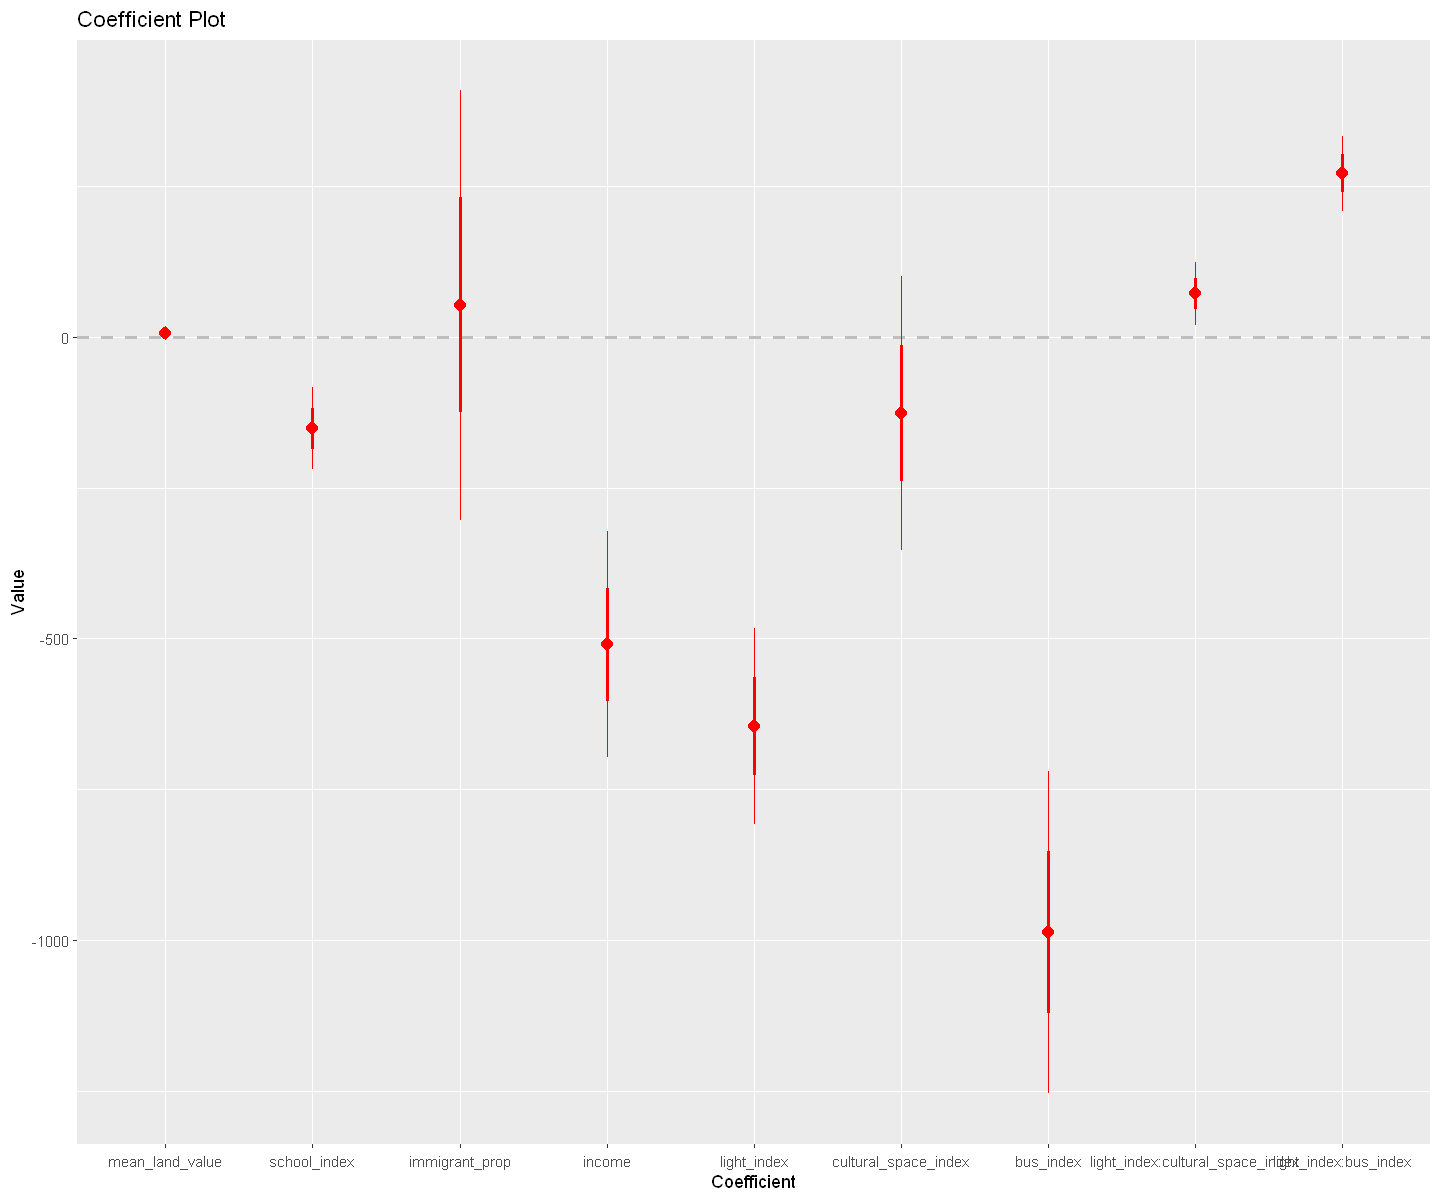

In [23]:
# Testing our specifications in final proposal, with robust standard error
reg_interaction <- lm(crime_rate ~ mean_land_value + school_index + immigrant_prop + income + light_index
     + cultural_space_index + bus_index + light_index:cultural_space_index + light_index:bus_index, data = census_index_crime)
     
se_interaction <- sqrt(diag(vcovHC(reg_interaction, type = "HC1")))

stargazer(reg_interaction, se = list(se_interaction), type = "text", dep.var.labels = c("Crime Rate"))

coefplot(reg_interaction, intercept = FALSE, horizontal = TRUE, color = "red")

Although all explanatory variables have large p-values, the model generally has a larger F statistic comparing to previous model including all variables. However the F statistic is still lower than that excluded "insignificant" controls.


                             Dependent variable:    
                         ---------------------------
                                 Crime Rate         
----------------------------------------------------
mean_land_value                     4.384           
                                   (5.597)          
                                                    
school_index                     -131.409***        
                                  (38.194)          
                                                    
immigrant_prop                     40.783           
                                  (193.928)         
                                                    
income                           -500.231***        
                                  (153.898)         
                                                    
light_index                      -848.232**         
                                  (363.246)         
                                             

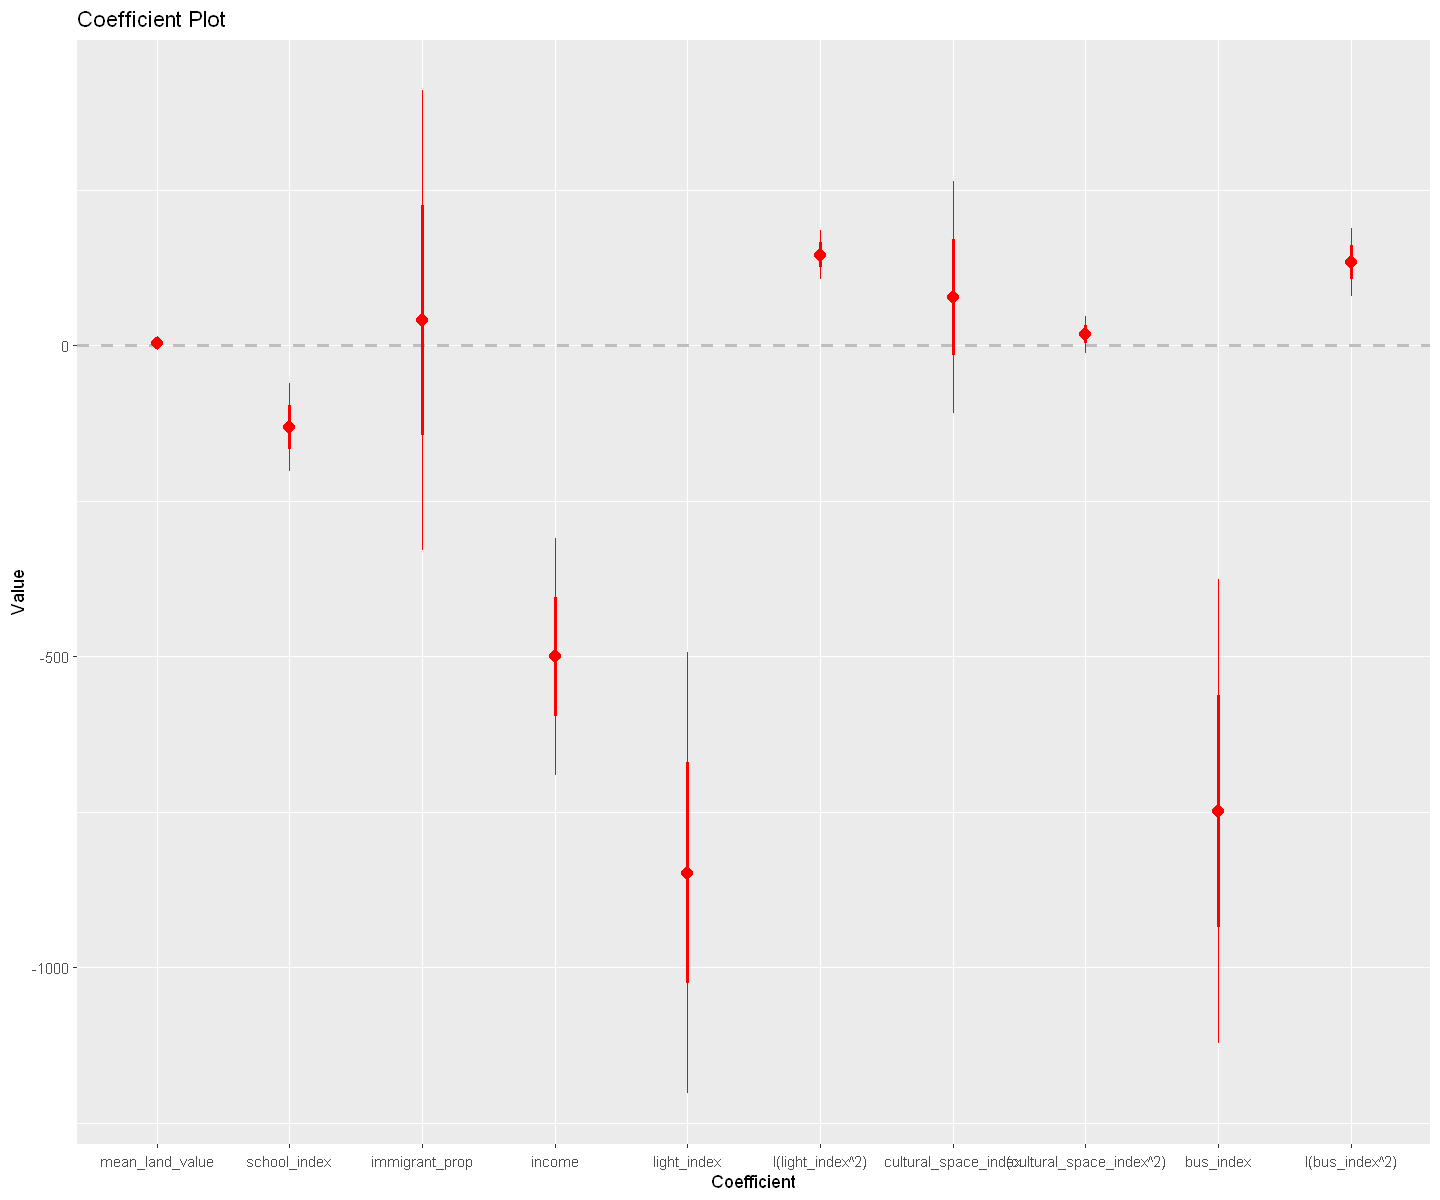

In [24]:
# Testing the specification with quadratic terms
reg_squared <- lm(crime_rate ~ mean_land_value + school_index + immigrant_prop + income + light_index + I(light_index^2)
     + cultural_space_index + I(cultural_space_index^2) + bus_index + I(bus_index^2), data = census_index_crime)
     
se_squared <- sqrt(diag(vcovHC(reg_squared, type = "HC1")))

stargazer(reg_squared, se =  list(se_interaction), type = "text", dep.var.labels = c("Crime Rate"))

coefplot(reg_squared, intercept = FALSE, horizontal = TRUE, color = "red")

We noticed a situation that is similar to the model with interaction happened.  

In [25]:
# Show four fitted models in a single output table
se_short <- sqrt(diag(vcovHC(reg1, type = "HC1")))

stargazer(reg1, reg_all, reg_interaction, reg_squared, se = list(se_short, se, se_interaction, se_squared), 
column.labels = c("short","all", "interaction", "squared"),  type = "text", dep.var.labels = c("Crime Rate"))


                                                                       Dependent variable:                                       
                                 ------------------------------------------------------------------------------------------------
                                                                            Crime Rate                                           
                                          short                    all                 interaction               squared         
                                           (1)                     (2)                     (3)                     (4)           
---------------------------------------------------------------------------------------------------------------------------------
mean_land_value                                                   7.986                   6.147                   4.384          
                                                                 (7.369)                 